Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import azureml.core
from azureml.core import Workspace
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
import os

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  0.1.0.32573435


In [3]:
project_folder=os.getcwd()
train_data_folder='trainDataset'
test_data_folder='testDataset'
script_folder = os.path.join(os.getcwd(), "scripts")
#script_folder=project_folder # for now I keep the scripts in the main folder
os.makedirs(script_folder, exist_ok=True)

### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [5]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
ws = Workspace(subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b' ,resource_group='20191107_DNNhyperdrive', workspace_name = 'WS1' )

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

AzureBlob ws11078562529 azureml-blobstore-15002b44-9629-4d8c-a66d-71dde33561ab
WS1	westeurope	20191107_DNNhyperdrive	westeurope


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [6]:
experiment_name = 'ImageClassifierhyperdrive'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [7]:
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           min_nodes=0,
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


In [8]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "y_train.tsv"),"rb") as f:
     y_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
with open(os.path.join('trainDataset', "y_val.tsv"),"rb") as f:
     y_val=pickle.load(f)

with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
with open(os.path.join('testDataset', "y_test.tsv"),"rb") as f:
     y_test=pickle.load(f)

In [9]:
with open(os.path.join('trainDataset', "encoder"),"rb") as f:
     encoder=pickle.load(f)

### Upload data to the cloud

In [11]:
ds.upload(src_dir=train_data_folder, target_path='trainDataset', overwrite=True, show_progress=True)
ds.upload(src_dir=test_data_folder, target_path='testDataset', overwrite=True, show_progress=True)

Uploading an estimated of 5 files
Uploading trainDataset\encoder
Uploaded trainDataset\encoder, 1 files out of an estimated total of 5
Uploading trainDataset\y_train.tsv
Uploaded trainDataset\y_train.tsv, 2 files out of an estimated total of 5
Uploading trainDataset\y_val.tsv
Uploaded trainDataset\y_val.tsv, 3 files out of an estimated total of 5
Uploading trainDataset\x_val.tsv
Uploaded trainDataset\x_val.tsv, 4 files out of an estimated total of 5
Uploading trainDataset\x_train.tsv
Uploaded trainDataset\x_train.tsv, 5 files out of an estimated total of 5
Uploaded 5 files
Uploading an estimated of 7 files
Uploading testDataset\encoder
Uploaded testDataset\encoder, 1 files out of an estimated total of 7
Uploading testDataset\y_test.tsv
Uploaded testDataset\y_test.tsv, 2 files out of an estimated total of 7
Uploading testDataset\y_val.tsv
Uploaded testDataset\y_val.tsv, 3 files out of an estimated total of 7
Uploading testDataset\y_train.tsv
Uploaded testDataset\y_train.tsv, 4 files out

$AZUREML_DATAREFERENCE_ed7f789470384d4e86e83d2812ee8328

### Preparation for the model

In [12]:
ntrain=len(x_train)
nval=len(x_val)
batch_size=32

In [13]:
y_val[1:5]

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [14]:
print(x_train.shape)
print(y_train.shape)

(1025, 150, 150, 3)
(1025, 8)


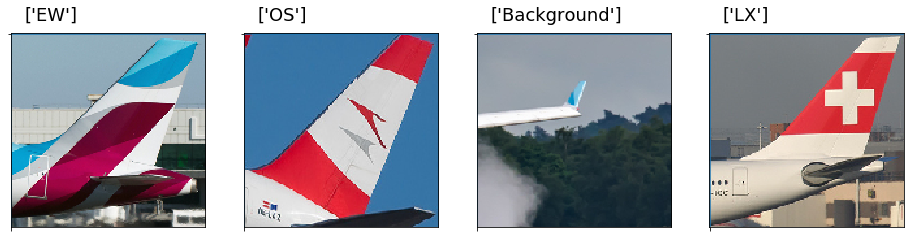

In [22]:
from utils import load_data

'''
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images-idx3-ubyte.gz'), False) / np.float32(255.0)
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / np.float32(255.0)
y_train = load_data(os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)


predicted=loaded_model.predict(x_test)
pred=[]
for p in predicted:
   # pred.append((p//np.amax(p)).astype(int))
    pred.append(np.argmax(p))
labelsText = encoder.inverse_transform(np.array(pred))


'''
count = 0
sample_size = 4
plt.figure(figsize = (16, 6))
for i in np.random.permutation(x_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = encoder.inverse_transform([np.argmax(y_train[i])]), fontsize = 18)
    #plt.imshow(x_train[i][:,:,0].reshape(150,-1), cmap = plt.cm.Greys)
    plt.imshow(x_train[i])
plt.show()

## Datasets

In [23]:
from azureml.core import Dataset
trainDataset = Dataset.File.from_files((ds, 'trainDataset/*'))
testDataset = Dataset.File.from_files((ds, 'testDataset/*'))


In [24]:
for dsname in ['train','test']:
    print(dsname)
    dslongname=dsname+'DatasetLH'
    dataset_registered = False
    try:
        temp = Dataset.get_by_name(workspace = ws, name = dslongname)
        dataset_registered = True
        print('............. found registered')
        print(temp.to_path())
    except:
        print("The dataset "+dslongname+" is not registered in workspace yet.")

    if not dataset_registered:
        dataset = Dataset.File.from_files((ds, dsname+'Dataset/*'))
        dataset = dataset.register(workspace = ws,
                                name = dslongname,
                                description=dsname + 'dataset',
                                create_new_version=True)
        # list the files referenced by dataset
        print(dataset.to_path())
    

train
The dataset trainDatasetLH is not registered in workspace yet.
['/encoder', '/x_train.tsv', '/x_val.tsv', '/y_train.tsv', '/y_val.tsv']
test
The dataset testDatasetLH is not registered in workspace yet.
['/encoder', '/x_test.tsv', '/x_train.tsv', '/x_val.tsv', '/y_test.tsv', '/y_train.tsv', '/y_val.tsv']


In [25]:
import os
os.listdir()
script_folder
training_script_file= os.path.join(project_folder,script_folder,'train.py')
training_script_file

'c:\\Users\\ankubasi\\OneDrive - Microsoft\\Documents\\Sandbox\\20210407_LH_demo_new\\tf_sample\\scripts\\train.py'

In [26]:
%%writefile ./scripts/train.py
import argparse
import os
import numpy as np
import pickle
from azureml.core.run import Run
from keras import layers, models, optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback
#import onnxmltools
import winmltools


'''
predicted=loaded_model.predict(x_test)
pred=[]
for p in predicted:
   # pred.append((p//np.amax(p)).astype(int))
    pred.append(np.argmax(p))
labelsText = encoder.inverse_transform(np.array(pred))
'''
run = Run.get_context()

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', help='batch_size')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.001,  help='learning rate')
parser.add_argument('--layer-size', type= int, dest='layer_size', default=1,  help='layer size factor')
args = parser.parse_args()

data_folder = args.data_folder
batch_size = args.batch_size
learning_rate = args.learning_rate

with open(os.path.join(data_folder, 'x_train.tsv'),"rb") as f:
    x_train = pickle.load(f)
with open(os.path.join(data_folder,'y_train.tsv'),"rb") as f:
    y_train = pickle.load(f)
with open(os.path.join(data_folder,'x_val.tsv'),"rb") as f:
    x_val = pickle.load(f)
with open(os.path.join(data_folder,'y_val.tsv'),"rb") as f:
    y_val = pickle.load(f)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, sep = '\n')

ntrain=len(x_train)
nval=len(x_val)


###################  modeling part

model=models.Sequential()
model.add(layers.Conv2D(16,(3,3),activation='relu',input_shape=x_train[0].shape))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(8,activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['accuracy']
             )

trainDataGen= ImageDataGenerator(
                    rescale=1.,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2
                    )
valDataGen=ImageDataGenerator(rescale=1.)

trainGenerator=trainDataGen.flow(x_train,y_train,batch_size = batch_size)
valGenerator=valDataGen.flow(x_val,y_val,batch_size = batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

class LogRunMetrics(Callback):

    # callback at the end of every epoch

    def on_epoch_end(self, epoch, log):
        # log a value repeated which creates a list
        run.log('Accuracy', log['accuracy'])
        run.log('Loss', log['loss'])
        
    
history=model.fit_generator(trainGenerator,
                            steps_per_epoch = ntrain//batch_size,
                            epochs = 32,
                            validation_data = valGenerator,
                            validation_steps = nval//batch_size,
                            callbacks=[early_stopping,LogRunMetrics()],
                            workers=3
                           )

run.log_list('val_accuracy', history.history['val_accuracy'], description='Validation accuracy')
run.log_list('val_loss', history.history['val_loss'], description='validation loss')


output_dir = './outputs/model'
os.makedirs(output_dir, exist_ok=True)


# serialize NN architecture to JSON
model_json = model.to_json()
# save model JSON
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)
# save model weights
model.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

with open('./outputs/model/trainHistoryDict', 'wb') as f:
        pickle.dump(history.history, f)



Overwriting ./scripts/train.py


Writing ./scripts/train_layersize.py


## Define Environment

In [27]:
%%writefile ./scripts/conda_dependencies.yml

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - tensorflow-gpu==2.0.0
  - keras<=2.3.1
  - matplotlib
  - winmltools

Overwriting ./scripts/conda_dependencies.yml


In [28]:
from azureml.core import Environment

keras_env = Environment.from_conda_specification(name='keras-env', file_path='./scripts/conda_dependencies.yml')

# Specify a GPU base image
keras_env.docker.enabled = True
keras_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'


## Configure the job 

1. Without hyperdrive

In [29]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', trainDataset.as_named_input('trainDatasetLHgray4D').as_mount(),
        '--batch-size', 64,
      #  '--layer-size', 1,
        '--learning-rate', 0.001]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env)

In [30]:
from azureml.widgets import RunDetails
run = experiment.submit(src)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

# With Hyperdrive

In [51]:
%%writefile ./scripts/train_layersize.py
import argparse
import os
import numpy as np
import pickle
from azureml.core.run import Run
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback
import onnx
import winmltools

run = Run.get_context()

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', help='batch_size')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.001,  help='learning rate')
parser.add_argument('--layer-size', type= int, dest='layer_size', default=1,  help='layer size factor')

args = parser.parse_args()

data_folder = args.data_folder
batch_size = args.batch_size
learning_rate = args.learning_rate
layer_size = args.layer_size

print('Layer size factor = ', layer_size)

with open(os.path.join(data_folder, 'x_train.tsv'),"rb") as f:
    x_train = pickle.load(f)
with open(os.path.join(data_folder,'y_train.tsv'),"rb") as f:
    y_train = pickle.load(f)
with open(os.path.join(data_folder,'x_val.tsv'),"rb") as f:
    x_val = pickle.load(f)
with open(os.path.join(data_folder,'y_val.tsv'),"rb") as f:
    y_val = pickle.load(f)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, sep = '\n')

ntrain=len(x_train)
nval=len(x_val)


###################  modeling part

model=models.Sequential()
model.add(layers.Conv2D(16*layer_size,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256*layer_size,activation='relu'))
model.add(layers.Dense(8,activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['accuracy']
             )

trainDataGen= ImageDataGenerator(
                    rescale=1.,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2
                    )
valDataGen=ImageDataGenerator(rescale=1.)

trainGenerator=trainDataGen.flow(x_train,y_train,batch_size = batch_size)
valGenerator=valDataGen.flow(x_val,y_val,batch_size = batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

class LogRunMetrics(Callback):

    # callback at the end of every epoch

    def on_epoch_end(self, epoch, log):
        # log a value repeated which creates a list
        run.log('Accuracy', log['accuracy'])
        run.log('Loss', log['loss'])
        
    
history=model.fit_generator(trainGenerator,
                            steps_per_epoch = ntrain//batch_size+1,
                            epochs = 32,
                            validation_data = valGenerator,
                            validation_steps = nval//batch_size+1,
                            callbacks=[early_stopping,LogRunMetrics()],
                            workers=3
                           )

run.log_list('val_accuracy', history.history['val_accuracy'], description='Validation accuracy')
run.log_list('val_loss', history.history['val_loss'], description='validation loss')


output_dir = './outputs/model'
os.makedirs(output_dir, exist_ok=True)


# serialize NN architecture to JSON
model_json = model.to_json()
# save model JSON
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)
# save model weights
model.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

with open('./outputs/model/trainHistoryDict', 'wb') as f:
        pickle.dump(history.history, f)



Overwriting ./scripts/train_layersize.py


In [55]:
from azureml.core import ScriptRunConfig

from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(32,64, 128),
        '--learning-rate': uniform(1e-4, 1e-3),
        '--layer-size': choice(1,2,4)
    }
)


args = ['--data-folder', trainDataset.as_named_input('trainDatasetLH').as_mount()]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train_layersize.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env)

policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)


In [56]:
hdc = HyperDriveConfig(run_config=src, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='validation_acc', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=8,
                       max_concurrent_runs=4)

### Submit the job to the cluster

Run the experiment by submitting the estimator object. And you can navigate to Azure portal to monitor the run.

In [40]:
%%writefile .amlignore
data
model
sourceData
Training
Testing
trainDataset
testDataset
dataLH
model_keras.h5
model_weights.h5
model_wieghts.h5
ARCH

Writing .amlignore


In [57]:
run = experiment.submit(config=hdc)
run

Experiment,Id,Type,Status,Details Page,Docs Page
ImageClassifierhyperdrive,HD_b3926e57-3971-4e32-a5b9-32190be41b8a,hyperdrive,Running,Link to Azure Machine Learning studio,Link to Documentation


## Monitor a remote run


In [59]:
from azureml.widgets import RunDetails
RunDetails(run).show()


_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO',…

### register model from best run

In [43]:
best_run = run.get_best_run_by_primary_metric()
model = best_run.register_model(model_name='kerasmodel', model_path="outputs/model")

print(model.name, model.id, model.version, sep = '\t')

onnxmodel	onnxmodel:6	6


![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)

# Deploy

In [44]:
%%writefile score.py

import json
import numpy as np
from azureml.core.model import Model
import onnxruntime as rt

def init():
    global session
    model_path = Model.get_model_path(model_name='onnxmodel')
    session = rt.InferenceSession(model_path)


def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    data = data.astype(np.float32)
    input_name = session.get_inputs()[0].name
    
    # make prediction
    res = session.run(None, {input_name: data})
    prob = res[0]

    return prob.tolist()

Overwriting score.py


### Serve model

===========================================================













==============================================================

In [45]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy","onnxruntime","azureml-defaults"]
                                )
myenv.add_conda_package('tensorflow')
myenv.add_conda_package('keras')
with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [46]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime="python",
                                   entry_script="score.py",
                                   conda_file="myenv.yml")

In [127]:
from azureml.core.webservice import  LocalWebservice  #                  <---------- LOCAL DEPLOYMENT IS MUCH FASTER
from azureml.core.model import Model

deployment_config = LocalWebservice.deploy_configuration()
service = Model.deploy(ws, "hyperdrivedservice", [model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)
print(service.state)

Generating Docker build context.
Package creation Succeeded
Package creation Succeeded
Logging into Docker registry demoimages64d1b10b.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM demoimages64d1b10b.azurecr.io/azureml/azureml_9addd638380b11aeec1f6735cb271a72
 ---> 073624575c6f
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> a16e89f00860
Step 3/5 : COPY model_config_map.json /var/azureml-app/model_config_map.json
 ---> d77877f459af
Step 4/5 : RUN mv '/var/azureml-app/tmpuaq4r7hq.py' /var/azureml-app/main.py
 ---> Running in bd3c8ccc2f3e
 ---> 7554f55666f8
Step 5/5 : CMD ["runsvdir","/var/runit"]
 ---> Running in e6e905ab4ff8
 ---> 0079939374f3
Successfully built 0079939374f3
Successfully tagged hyperdrivedservice:latest
Starting Docker container...
Docker container running.
Checking container health...
Local webservice is running at http://localhost:32773
running


===========================================================













==============================================================

In [124]:
with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
        
import json

idx=3
test_sample_x=x_test[idx]
test_sample_y=y_test[idx]


testx=np.expand_dims(test_sample_x, axis=0)
testxy=test_sample_y

print(testx.shape)
test_sample=json.dumps({'data':testx.tolist()})

(1, 150, 150, 3)


In [50]:
import requests

# create the required header
headers = {'Content-Type':'application/json'}
print('calling ', service.scoring_uri)
# post the request to the service and display the result
resp = requests.post(service.scoring_uri, test_sample, headers = headers)
print(resp.text)
output  = resp.text

calling  http://localhost:32770/score
[[0.9998139142990112, 0.0, 2.9802322387695312e-08, 0.0, 0.0, 2.9802322387695312e-08, 0.005098700523376465, 5.081295967102051e-05]]


In [61]:
def Convert(InputString): 
    string= InputString.replace('[','')
    string= string.replace(']','')
    string=string.replace(' ', '')
    li = list(string.split(",")) 
    return li 
  

In [117]:
result=np.array(Convert(output))
result=pd.DataFrame(np.around(result.astype(np.float),2),columns=['predicted'])
result['MaxVal']=''
MostProbable=result.predicted.idxmax()
result['MaxVal'][MostProbable]= ' *'
result


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,predicted,MaxVal
0,1.00,*
1,0.00,
2,0.00,
3,0.00,
4,0.00,
5,0.00,
6,0.01,
7,0.00,


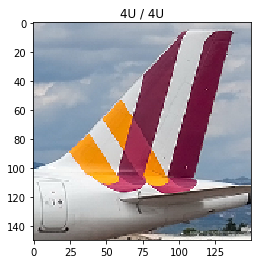

In [125]:
plt.figure()
labelsValid=np.core.defchararray.add(np.core.defchararray.add(test_sample_y,' / '),predictedLabel[0])

title_obj=plt.title(labelsValid, fontsize=12)
if (predictedLabel[0]!=test_sample_y):
        plt.setp(title_obj, color='r') 
plt.imshow(test_sample_x)